In [1]:
import pyspeckit as psk
import pyspeckit.spectrum.models.ammonia_constants as nh3const
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

This builds up an equivalent-width formalism for treating the ammonia model in RADEX.  RADEX (I think) assumes a Gaussian line width model.  Using our formalism, we have that
$$ \alpha(\nu) = \frac{c^2}{4\pi} \frac{1}{\nu_0^2}\frac{g_u}{g_l} n_l A_{ul}\left[1-\exp\left(\frac{h\nu}{kT_{ex}}\right)\right] \phi(\nu) = C n_l \, \phi(\nu)$$
Integrating over line of sight depth gives the specific optical depth:
$$ \tau(\nu) = \int ds\,\frac{c^2}{4\pi} \frac{1}{\nu_0^2}\frac{g_u}{g_l} n_l A_{ul}\left[1-\exp\left(\frac{h\nu}{kT_{ex}}\right)\right] \phi(\nu) = C N_l\, \phi(\nu)$$
Thus, it suffices to compare the two different line shape functions. Internally, we use a multi-Gaussian model for the line profile
$$\phi_{\mathrm{hfs}}(\nu) = \sum_i \frac{w_i}{\sqrt{2\pi}\sigma_\nu} \exp\left[-\frac{(\nu - \nu_0 - \delta\nu_i)^2}{2\sigma_\nu^2}\right]$$
RADEX presumably uses a Gaussian model with 
$$\phi_{\mathrm{g}}(\nu) = \frac{1}{\sqrt{2\pi}\sigma_{\nu,g}} \exp\left[-\frac{(\nu - \nu_0)^2}{2\sigma_{\nu,g}^2}\right]$$
Thus, we aim to mimic the distribution of values of $\phi_{\mathrm{hfs}}$ for a line width of $\sigma_\nu$ using using a Gaussian with a modified spectral width $\sigma_{\nu,g}$.  For a simple Gaussian distribution, this isn't possible to do perfectly.  Instead, we use a model where we broaden the Gaussian line width so that the maximum of the Gaussian line profile function with the modified line width is the same as for the ammonia distribution.  The integral will still be set to 1. First, let's measure the ratio of areas between an ammonia profile and a Gaussian profile with the same width and peak amplitude as the ammonia profile.  
$$\phi^*_{\mathrm{g}}(\nu) = \frac{\max[\phi_{\mathrm{hfs}}(\nu)]}{\sqrt{2\pi}\sigma_{\nu}} \exp\left[-\frac{(\nu - \nu_0)^2}{2\sigma_{\nu}^2}\right]$$
Then the line width we plug into RADEX should be:
$$\sigma_{v,g} = \sigma_{v,\mathrm{hfs}} \frac{\int \phi_{\mathrm{hfs}}(\nu) d\nu }{\int \phi^*_{\mathrm{g}}(\nu) d\nu}$$

In [109]:
lines = nh3const.line_names

# Search up to 10 km/s
sigmav = np.logspace(np.log10(0.05),1,51)

# equivalent width for spectral profiles at a given line width
EW_hf = np.zeros((len(lines), len(sigmav)))
EW_gauss = np.zeros((len(lines), len(sigmav)))
vax = np.linspace(-100,100,10001)
dv = vax[1]-vax[0]

for i, thisline in enumerate(lines):
    voff = nh3const.voff_lines_dict[thisline]
    wts = np.array(nh3const.tau_wts_dict[thisline])
    wts = wts / wts.sum()
    for j, sig in enumerate(sigmav):
        spec = np.zeros_like(vax)
        for w, v in zip(wts, voff):
            spec += w * np.exp(-(vax - v)**2/(2 * sig**2)) / (np.sqrt(2*np.pi) * sig) * dv
        gauss = spec.max() * np.exp(-vax**2/(2*sig**2))
        EW_hf[i, j] = np.sum(spec)
        EW_gauss[i, j] = np.sum(gauss)

Let's take a look at how far off our equivalent width distribution is for the $(1,1)$ line.  The distributions don't match too well but the max opacity is correctly matched.  The (1,1) line has more low opacity parts of the spectrum but the high opacity parts of the distribution match well.

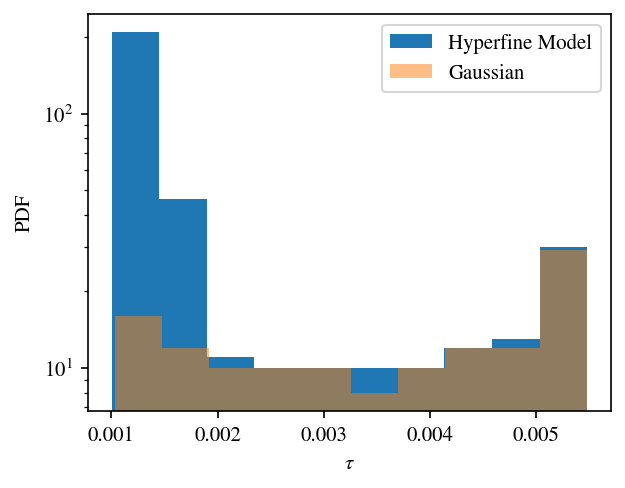

In [130]:
wts = np.array(nh3const.tau_wts_dict['oneone'])
voff = nh3const.voff_lines_dict['oneone']
wts = wts / wts.sum()
sig = 0.7
spec = np.zeros_like(vax)
for w, v in zip(wts, voff):
    spec += w * np.exp(-(vax - v)**2/(2 * sig**2)) / (np.sqrt(2*np.pi) * sig) * dv
gauss = spec.max() * np.exp(-vax**2/(2*sig**2))

fig, ax = plt.subplots(1,1)
ax.hist((spec[spec>0.001]), label='Hyperfine Model',log=True)
ax.hist((gauss[gauss>0.001]),alpha=0.5, label='Gaussian',log=True)
ax.legend()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('PDF')
fig.set_size_inches(4.5, 3.5)

Now that we've measured the ratio of the areas, we want to scale the width of the Gaussian up by this ratio to reduce the max amplitude of the Gaussian profile by the same ratio.  We fit a power-law relationship between this scaling for each line:
$$ \log_{10} \sigma_{v,g} = c_1 \log_{10} \sigma_{v,\mathrm{hfs}} + c_0$$
where the velocities here are expressed in km/s.

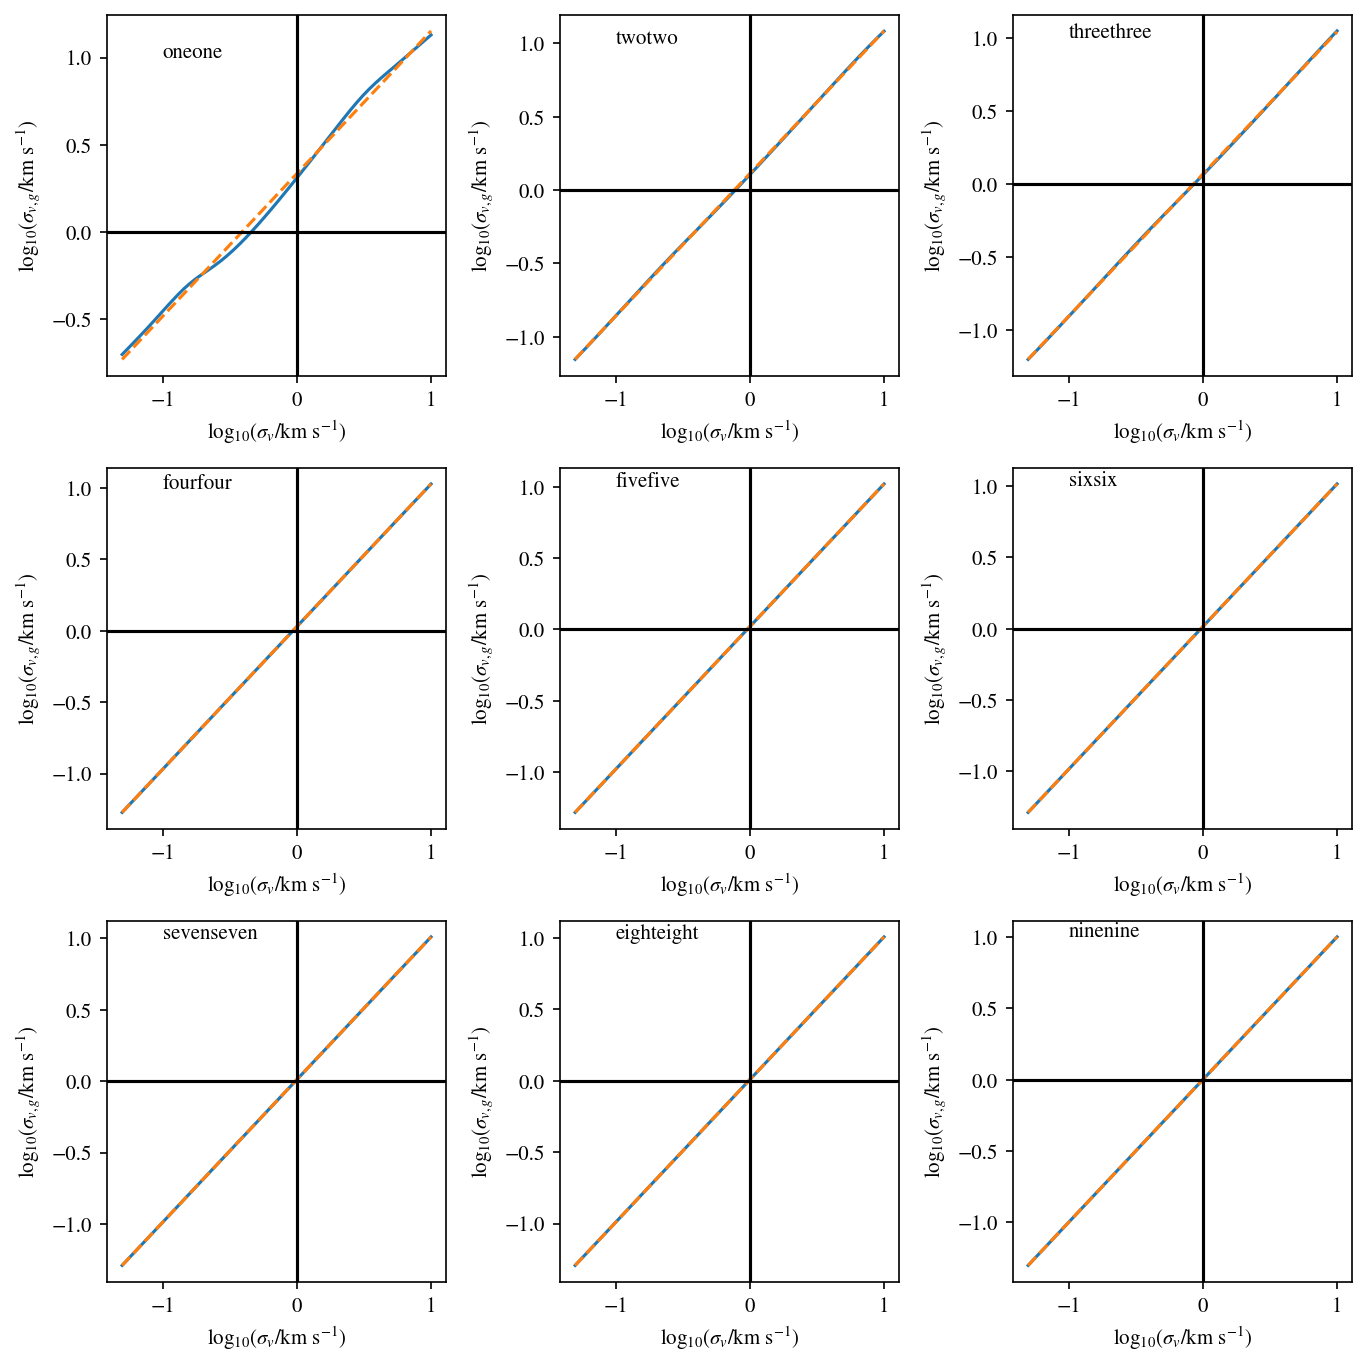

In [110]:
fig, axlist = plt.subplots(3,3, constrained_layout=True)
fig.set_size_inches(9,9)
coeffarray = np.zeros((len(lines),2))
for i, ax in enumerate(axlist.flatten()):
    ax.plot(np.log10(sigmav), np.log10(sigmav * np.squeeze(EW_hf[i]/EW_gauss[i])), label='Empirical')
    coeffs = np.polyfit(np.log10(sigmav), np.log10(sigmav * np.squeeze(EW_hf[i]/EW_gauss[i])), 1)
    coeffarray[i, :] = coeffs
    ax.plot(np.log10(sigmav), np.polyval(coeffs, np.log10(sigmav)),linestyle='--', label='Fit')
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_xlabel(r'$\log_{10}(\sigma_v/\mathrm{km\ s^{-1}})$')
    ax.set_ylabel(r'$\log_{10}(\sigma_{v,g}/\mathrm{km\ s^{-1}})$')
    ax.text(-1,1,lines[i])
#     ax.legend()


Given these coefficients, we transform a given velocity dispersion to a line appropriate velocity dispersion for that line using $c_0, c_1$ as defined above.


We have one final issue though.  The transfer of the different states has different corrections to the line width because the HF components have different spacings for different $J,K$ states. This means we do a different lookup for the different lines but this means that we're solving the radiative transfer problem inconsistently (i.e., a lower opacity $(1,1)$ line would affect the population in $(2,2)$.